[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/10-ME/full_search_block_ME.ipynb)

# Full search block-based ME (Motion Estimation)
The predicted frame is divided into blocks and each one is characterized by a motion vector using exhaustive search. This guarantees reaching the global optimal (the best motion field).

In [1]:
import numpy as np
!ln -sf ~/MRVC/src/image_3.py .
import image_3
!ln -sf ~/MRVC/src/image_1.py .
import image_1
!ln -sf ~/MRVC/src/YCoCg.py .
import YCoCg as YUV
!ln -sf ~/MRVC/src/motion.py .
import motion
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv
plt.rcParams['text.usetex'] = True
!ln -sf ~/quantization/information.py .
import information

OFCA: default number of levels = 3
OFCA: default window size = 33x33
OFCA: default number of iterations = 3
OFCA: extension mode = 1
OFCA: default poly_n 7
OFCA: default poly_sigma 1.5


In [2]:
R = YUV.from_RGB(image_3.read("/home/vruiz/MRVC/sequences/moving_circles/", 0).astype(np.int16))[...,0]
P = YUV.from_RGB(image_3.read("/home/vruiz/MRVC/sequences/moving_circles/", 1).astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/moving_circles/000.png (64, 64, 3) uint8 684 
image_3.read: /home/vruiz/MRVC/sequences/moving_circles/001.png (64, 64, 3) uint8 684 


255 0 int16


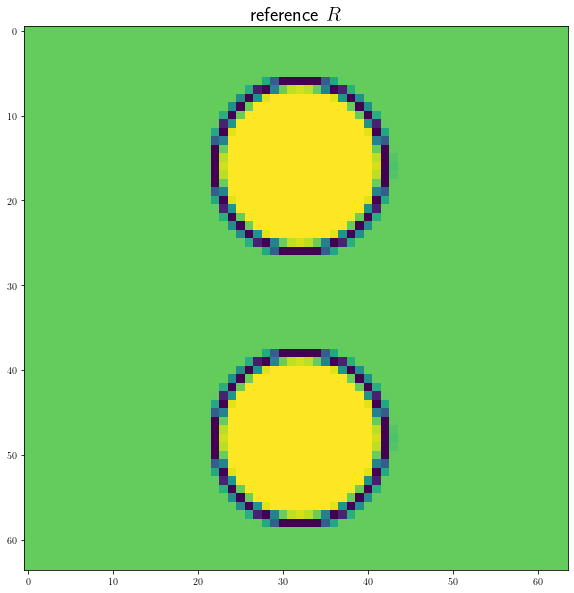

In [3]:
image_1.show(R, "reference $R$")

255 0 int16


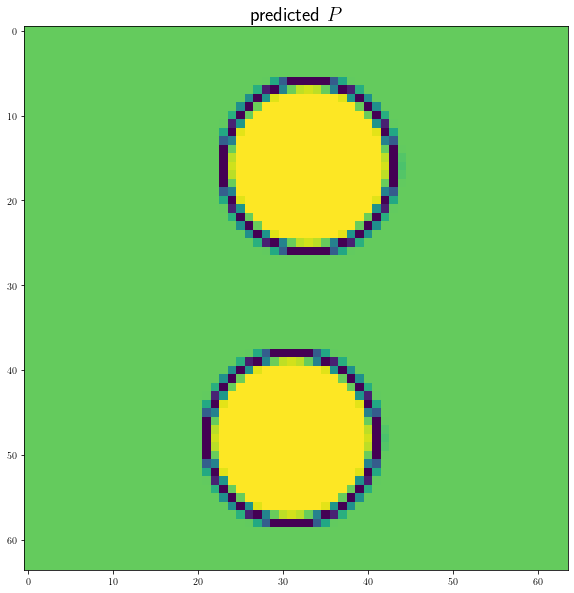

In [4]:
image_1.show(P, "predicted $P$")

The top circle moves to the right and the bottom circle moves to the left. Therefore, if we want to generate the predicted frame (bottom) from the reference one (top), all the top MVs (Motion Vectors) related to the circle should be (x=1, y=0), and all the bottom MVs (-1, 0).

In [5]:
def full_search_block_based_ME(P, R, block_side=16, max_abs_motion=8):
    
    def local_search(by, bx):
        errors_by_search_area = np.empty((2*max_abs_motion + 1, 2*max_abs_motion + 1))
        for ry in range(-max_abs_motion, max_abs_motion + 1):
            for rx in range(-max_abs_motion, max_abs_motion + 1):
                R_block = extended_R[by*block_side + ry + max_abs_motion:
                                    (by + 1)*block_side + ry + max_abs_motion,
                                    bx*block_side + rx + max_abs_motion:
                                    (bx + 1)*block_side + rx + max_abs_motion]
                #show_frame(R_block, f"R ({by} {bx} {ry} {rx} {by*block_side + ry + max_abs_motion}:{(by + 1)*block_side + ry + max_abs_motion}, {bx*block_side + rx + max_abs_motion}:{(bx + 1)*block_side + rx + max_abs_motion})")
                P_block = P[by*block_side : (by + 1)*block_side, bx*block_side : (bx + 1)*block_side]
                #show_frame(P_block, f"P ({by*block_side}:{(by + 1)*block_side},{bx*block_side}:{(bx + 1)*block_side})")
                #errors_in_search_area = np.abs(R_block - P_block)
                #error_by_block = np.sum(errors_in_search_area)
                error = R_block.astype(np.float32) - P_block
                errors_in_search_area = error*error
                error_by_block = np.average(errors_in_search_area)
                #show_frame(errors_in_search_area, f"by={by} bx={bx} ry={ry} rx={rx} error={error_by_block}")
                errors_by_search_area[ry + max_abs_motion, rx + max_abs_motion] = error_by_block
                #show_frame(errors_by_search_area, "errors")
        mv_index = np.argmin(errors_by_search_area)
        if errors_by_search_area[max_abs_motion, max_abs_motion] == errors_by_search_area[0, 0]:
            MV_y, MV_x = 0, 0
        else:
            MV_y = mv_index // (2*max_abs_motion + 1) - max_abs_motion
            MV_x = mv_index  % (2*max_abs_motion + 1) - max_abs_motion
        #print("index=", mv_index, "y=", MV_y, "x=", MV_x)
        #print(errors_by_search_area.astype(np.int))
        return MV_y, MV_x

    assert max_abs_motion > 0
    extended_R = cv.copyMakeBorder(R, max_abs_motion, max_abs_motion, max_abs_motion, max_abs_motion, cv.BORDER_REPLICATE) 
    extended_R[max_abs_motion : R.shape[0] + max_abs_motion,
               max_abs_motion : R.shape[1] + max_abs_motion] = R
    #show_frame(extended_R, "extended R")
    blocks_in_y = P.shape[0]//block_side
    blocks_in_x = P.shape[1]//block_side
    MVs = np.zeros((blocks_in_y, blocks_in_x, 2), dtype=np.int8)
    #print(blocks_in_y, blocks_in_x)
    for by in range(blocks_in_y):
        for bx in range(blocks_in_x):
            MV_y, MV_x = local_search(by, bx)
            MVs[by, bx] = (MV_x, MV_y)
    return MVs

block_side = 32
max_abs_motion = 1
MVs = full_search_block_based_ME(P, R, block_side=block_side, max_abs_motion=max_abs_motion)

In [6]:
MVs.shape

(2, 2, 2)

In [7]:
for y in range(P.shape[0]//block_side):
    for x in range(P.shape[1]//block_side):
        print(MVs[y, x], end=' ')
    print()

[-1  0] [-1  0] 
[1 0] [1 0] 


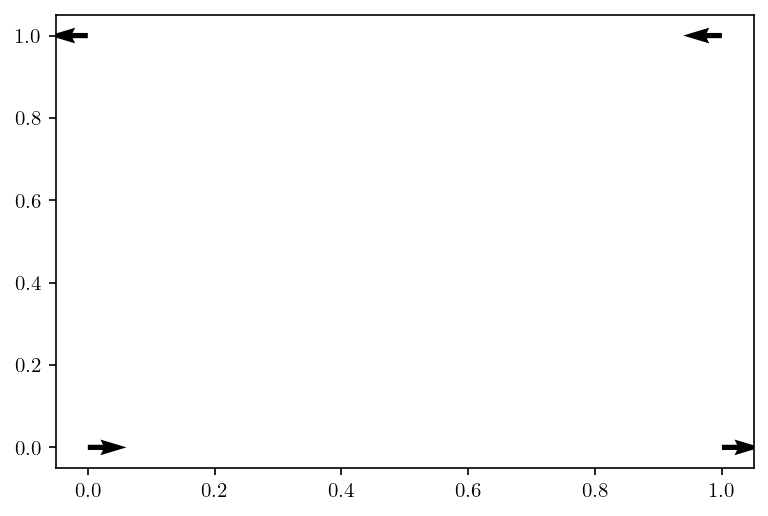

In [8]:
motion.show_vectors(MVs[::1, ::1])

## Interpolate the MVs
The predictor expects a dense motion field.

In [9]:
from scipy import ndimage
_MVs = np.empty((P.shape[0], P.shape[1], 2), dtype=np.float32)
print(_MVs.shape)
_MVs[..., 0] = ndimage.zoom(MVs[..., 0], P.shape[0]/MVs.shape[0], order=0)
_MVs[..., 1] = ndimage.zoom(MVs[..., 1], P.shape[0]/MVs.shape[0], order=0)

(64, 64, 2)


## Make the prediction

255 0 int16
255 0 int16
255 0 int16
0 0 int16


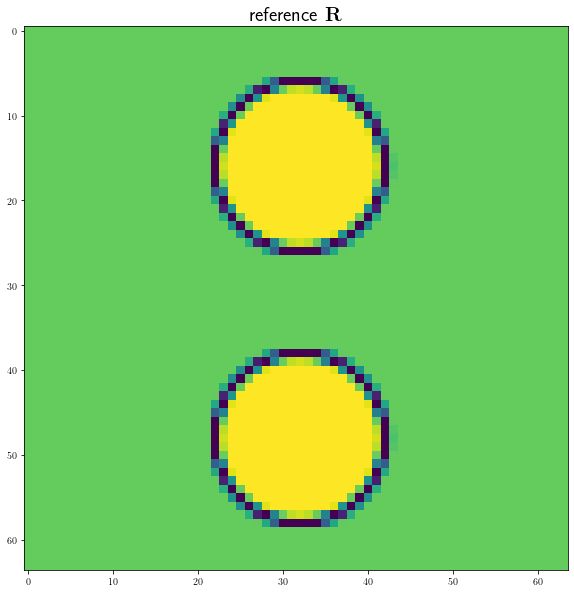

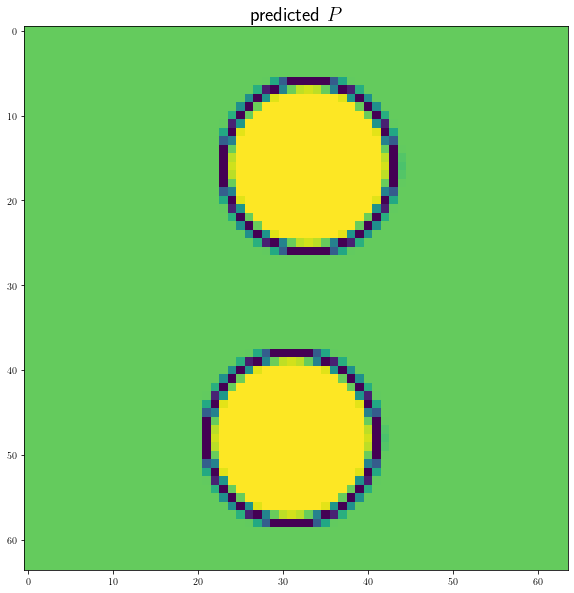

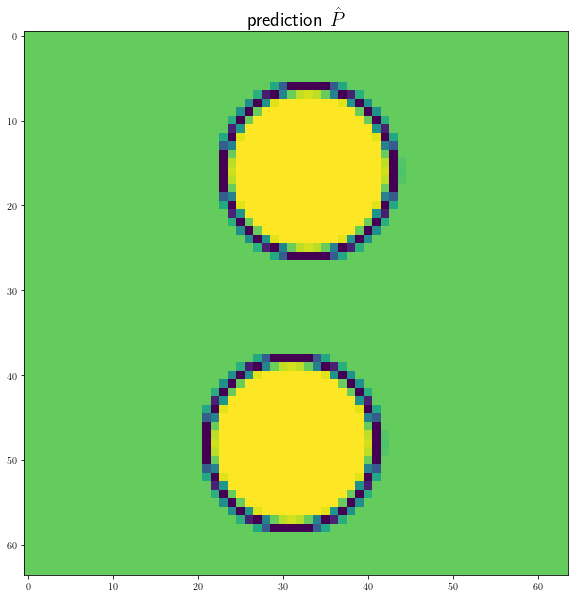

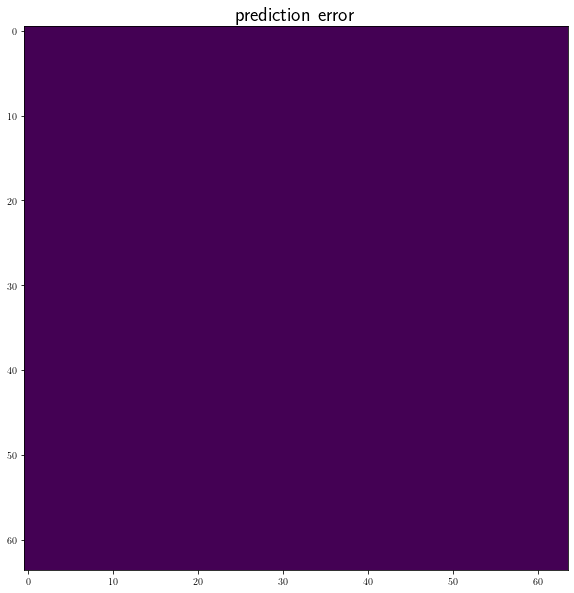

In [10]:
hat_P = motion.make_prediction(R, _MVs)
image_1.show(R, "reference ${\mathbf R}$")
image_1.show(P, "predicted $P$")
image_1.show(hat_P, "prediction $\hat{P}$")
image_1.show(P-hat_P, "prediction error")

## More distance

In [11]:
R = YUV.from_RGB(image_3.read("/home/vruiz/MRVC/sequences/moving_circles/", 0).astype(np.int16))[...,0]
P = YUV.from_RGB(image_3.read("/home/vruiz/MRVC/sequences/moving_circles/", 2).astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/moving_circles/000.png (64, 64, 3) uint8 684 
image_3.read: /home/vruiz/MRVC/sequences/moving_circles/002.png (64, 64, 3) uint8 684 


255 0 int16
255 0 int16


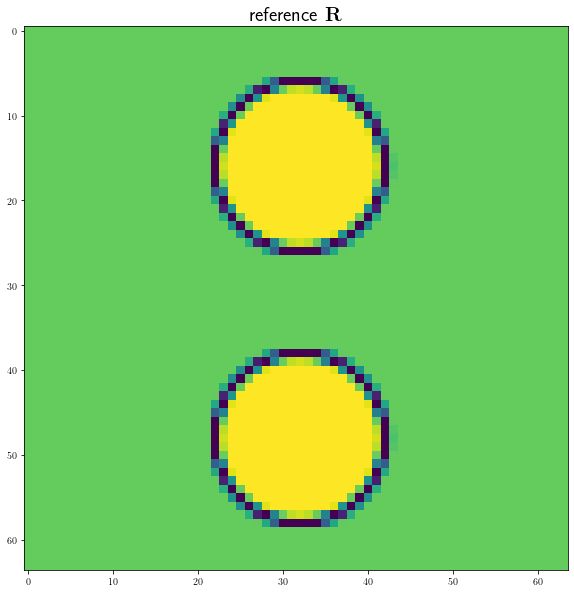

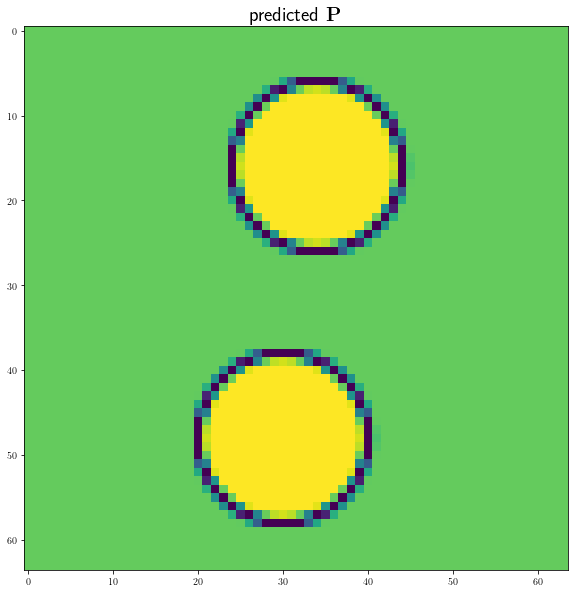

In [12]:
image_1.show(R, "reference ${\mathbf R}$")
image_1.show(P, "predicted ${\mathbf P}$")

In [13]:
block_side = 16
max_abs_motion = 4
MVs = full_search_block_based_ME(P, R, block_side=block_side, max_abs_motion=max_abs_motion)

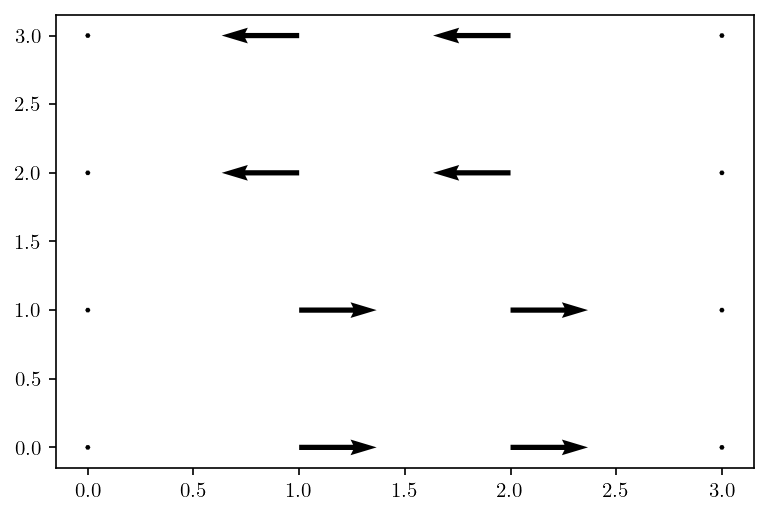

In [14]:
motion.show_vectors(MVs[::1, ::1])

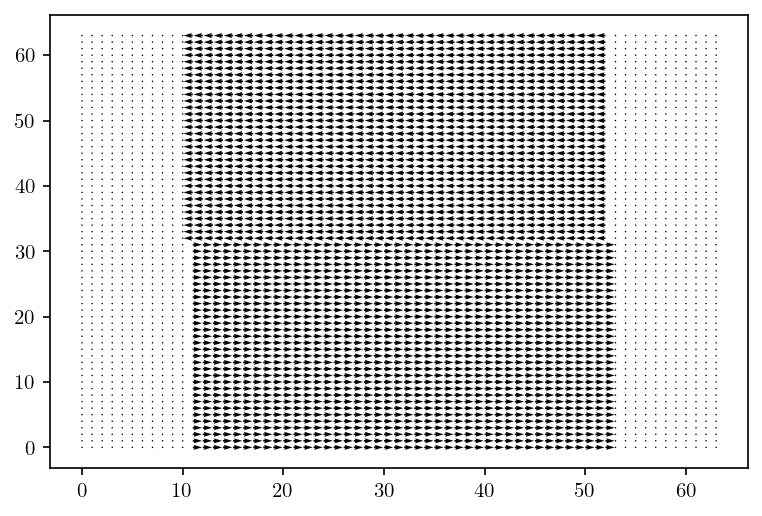

In [15]:
from scipy import ndimage
_MVs = np.empty((P.shape[0], P.shape[1], 2), dtype=np.float32)
_MVs[..., 0] = ndimage.zoom(MVs[..., 0], P.shape[0]/MVs.shape[0], order=0)
_MVs[..., 1] = ndimage.zoom(MVs[..., 1], P.shape[0]/MVs.shape[0], order=0)
motion.show_vectors(_MVs[::1, ::1])

255 0 int16
0 0 int16


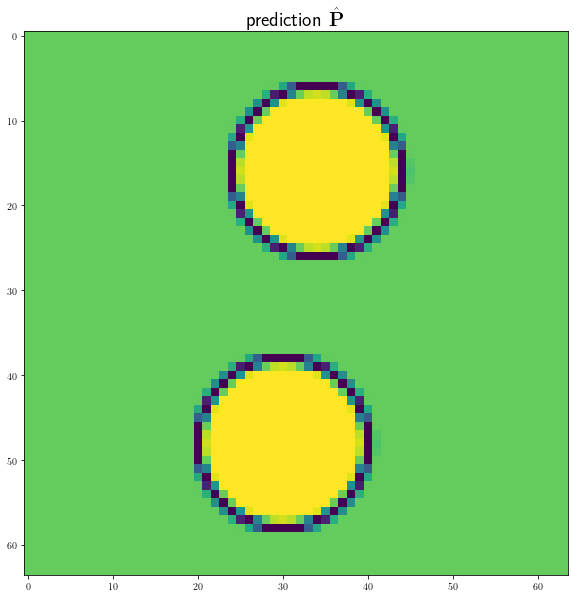

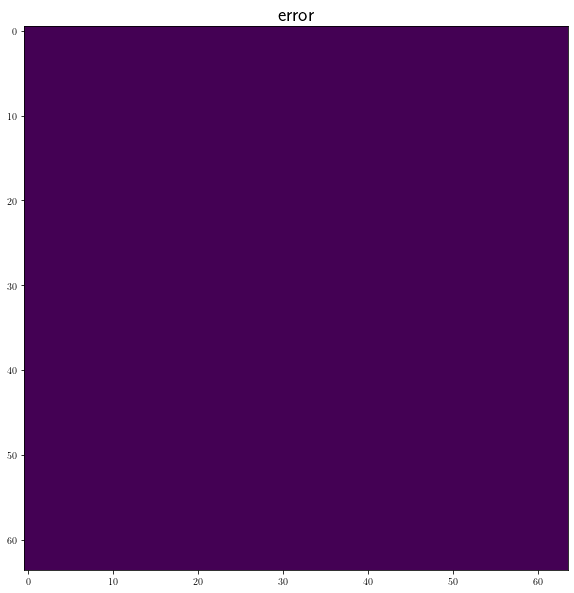

In [16]:
hat_P = motion.make_prediction(R, _MVs)
image_1.show(hat_P, "prediction $\hat{\mathbf P}$")
image_1.show(P-hat_P, "error")

## Even more distance

In [17]:
R = YUV.from_RGB(image_3.read("/home/vruiz/MRVC/sequences/moving_circles/", 0).astype(np.int16))[...,0]
P = YUV.from_RGB(image_3.read("/home/vruiz/MRVC/sequences/moving_circles/", 4).astype(np.int16))[...,0]

image_3.read: /home/vruiz/MRVC/sequences/moving_circles/000.png (64, 64, 3) uint8 684 
image_3.read: /home/vruiz/MRVC/sequences/moving_circles/004.png (64, 64, 3) uint8 684 


255 0 int16
255 0 int16


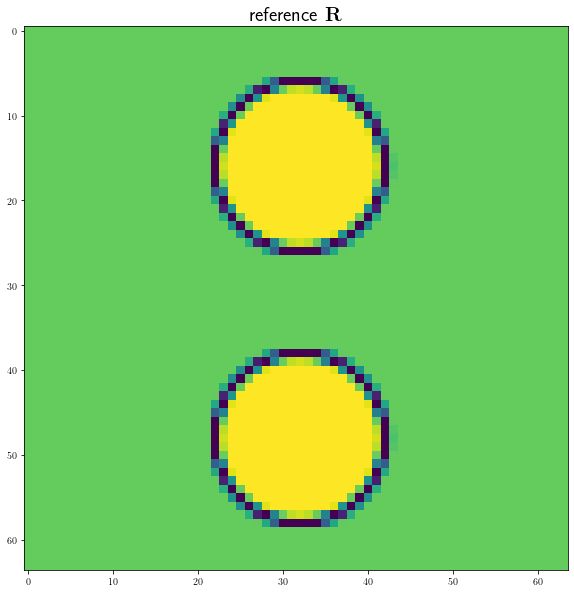

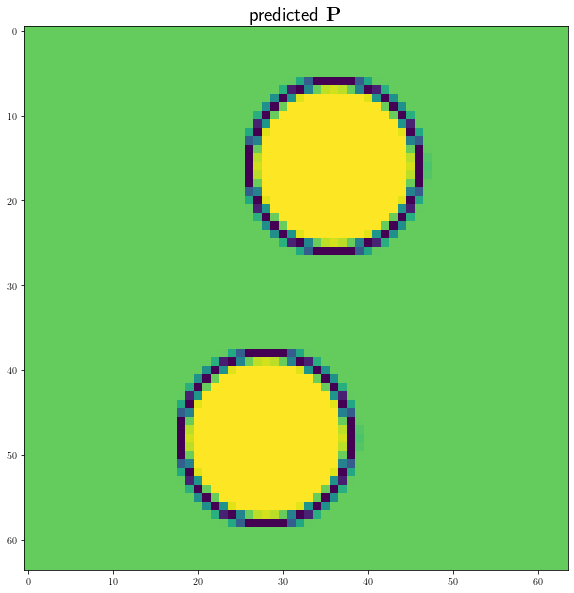

In [18]:
image_1.show(R, "reference ${\mathbf R}$")
image_1.show(P, "predicted ${\mathbf P}$")

In [19]:
block_side = 16
max_abs_motion = 8
MVs = full_search_block_based_ME(P, R, block_side=block_side, max_abs_motion=max_abs_motion)

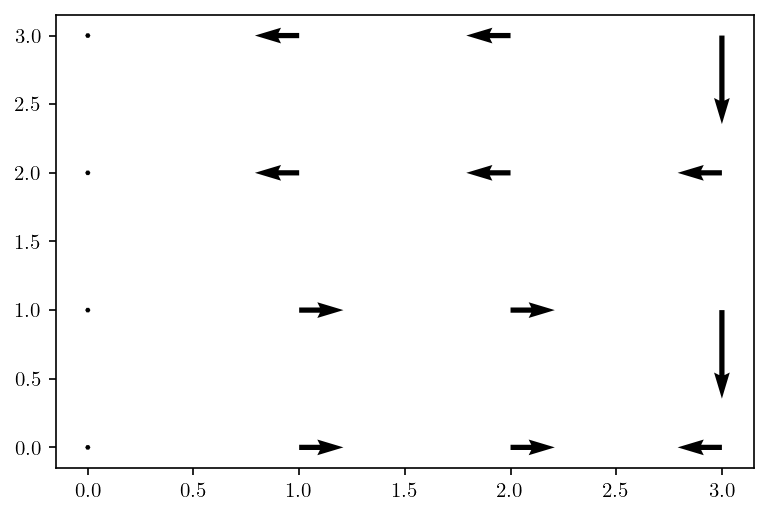

In [20]:
motion.show_vectors(MVs[::1, ::1])

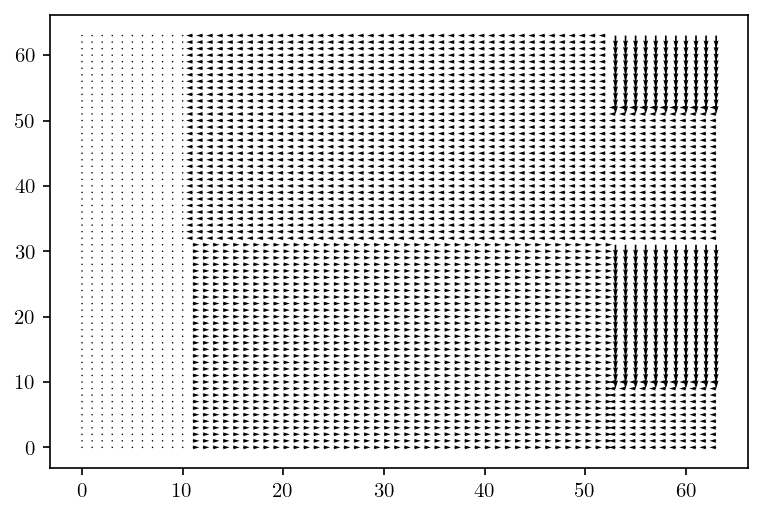

In [21]:
from scipy import ndimage
_MVs = np.empty((P.shape[0], P.shape[1], 2), dtype=np.float32)
_MVs[..., 0] = ndimage.zoom(MVs[..., 0], P.shape[0]/MVs.shape[0], order=0)
_MVs[..., 1] = ndimage.zoom(MVs[..., 1], P.shape[0]/MVs.shape[0], order=0)
motion.show_vectors(_MVs[::1, ::1])

255 0 int16
0 0 int16


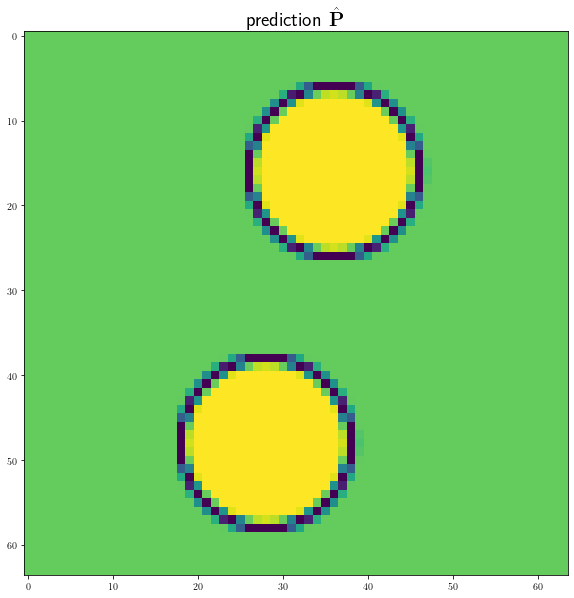

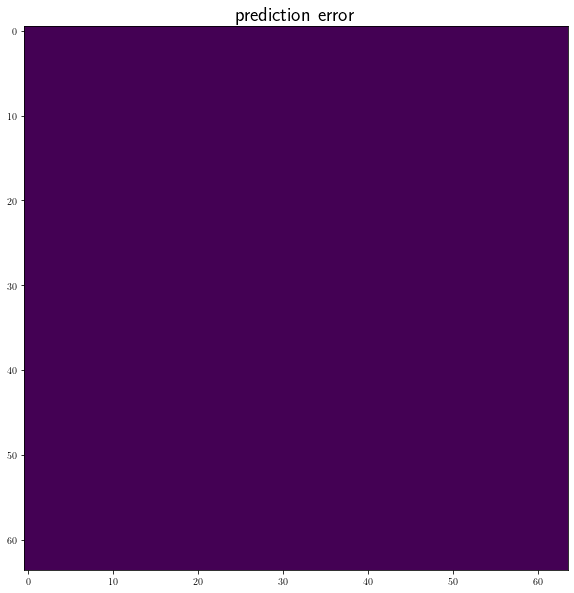

In [22]:
hat_P = motion.make_prediction(R, _MVs)
image_1.show(hat_P, "prediction $\hat{\mathbf P}$")
image_1.show(P-hat_P, "prediction error")

## Now with a real image

### ... but first without using ME
Notice that we work only with a tile of the original image.

image_3.read: /home/vruiz/MRVC/sequences/stockholm/000.png (768, 1280, 3) uint8 1927590 
image_3.read: /home/vruiz/MRVC/sequences/stockholm/001.png (768, 1280, 3) uint8 1927644 
component=0 max=255 min=0 dtype=uint8
component=1 max=251 min=0 dtype=uint8
component=2 max=246 min=0 dtype=uint8
component=0 max=255 min=0 dtype=uint8
component=1 max=251 min=0 dtype=uint8
component=2 max=242 min=0 dtype=uint8
component=0 max=255 min=0 dtype=uint8
component=1 max=255 min=0 dtype=uint8
component=2 max=255 min=0 dtype=uint8


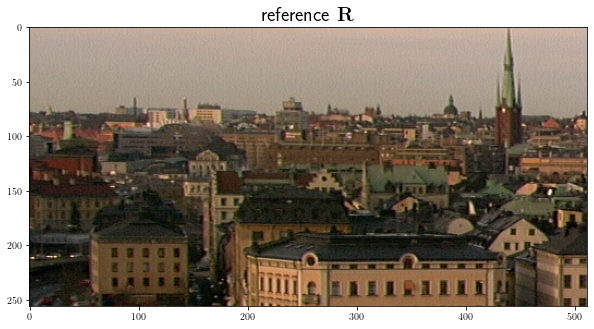

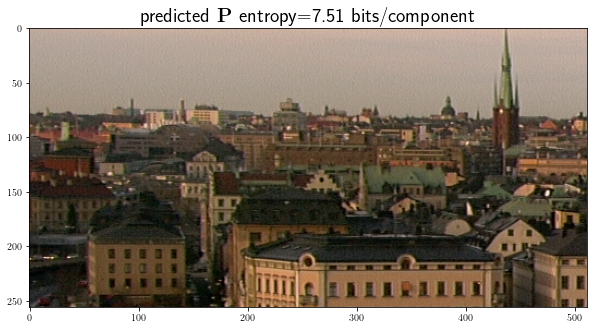

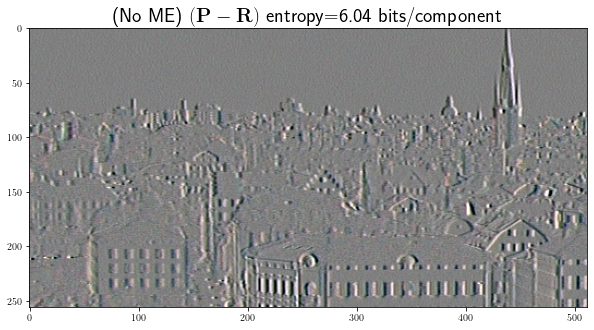

In [31]:
slice_Y = slice(100,356)
slice_X = slice(100,612)
prefix = "/home/vruiz/MRVC/sequences/stockholm/"
R = image_3.read(prefix, 0)[slice_Y, slice_X]
P = image_3.read(prefix, 1)[slice_Y, slice_X]
image_3.show(R, "reference ${\mathbf R}$")
entropy = information.entropy(P.flatten())
image_3.show(P, "predicted ${\mathbf P}$" + f" entropy={entropy:1.2f} bits/component")
predicted_entropy = entropy
P_R = np.clip(P.astype(np.int16) - R + 128, 0, 255)
entropy = information.entropy(P_R.flatten())
image_3.show(P_R.astype(np.uint8), "(No ME) $({\mathbf P} - {\mathbf R})$" + f" entropy={entropy:1.2f} bits/component")

### ... and now using BBME

In [24]:
block_side = 16
max_abs_motion = 8
MVs = full_search_block_based_ME(P, R, block_side=block_side, max_abs_motion=max_abs_motion)

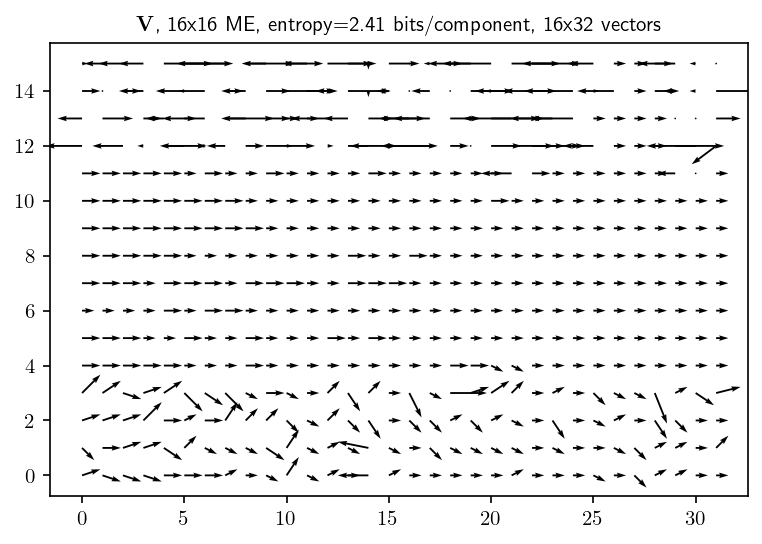

In [25]:
entropy = information.entropy(MVs.flatten())
motion_entropy = entropy
motion.show_vectors(MVs[::1, ::1], title="${\mathbf V}$" + f", {block_side}x{block_side} ME" + f", entropy={entropy:1.2f} bits/component" +  f", {MVs.shape[0]}x{MVs.shape[1]} vectors")

In [26]:
P.shape[0]/block_side

16.0

In [27]:
P.shape[1]/block_side

32.0

In [28]:
from scipy import ndimage
zoom_MVs = np.empty((P.shape[0], P.shape[1], 2), dtype=np.float32)
print(_MVs.shape)
zoom_MVs[..., 0] = ndimage.zoom(MVs[..., 0], P.shape[0]/MVs.shape[0], order=0)
zoom_MVs[..., 1] = ndimage.zoom(MVs[..., 1], P.shape[0]/MVs.shape[0], order=0)

(64, 64, 2)


component=0 max=255 min=0 dtype=uint8
component=1 max=251 min=0 dtype=uint8
component=2 max=246 min=0 dtype=uint8
component=0 max=216 min=45 dtype=uint8
component=1 max=202 min=50 dtype=uint8
component=2 max=199 min=47 dtype=uint8


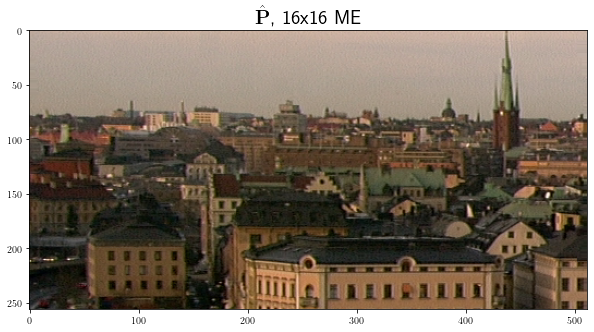

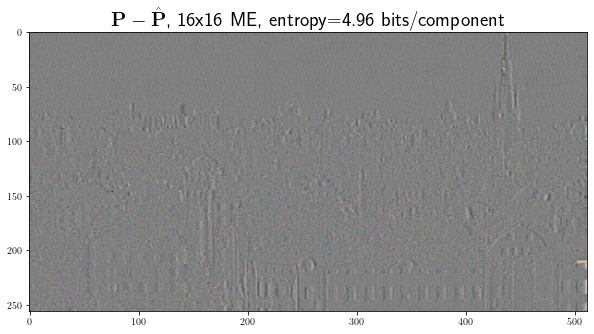

In [29]:
hat_P = motion.make_prediction(R, zoom_MVs)
image_3.show(hat_P, "$\hat{\mathbf P}$" + f", {block_side}x{block_side} ME")
P_hat_P = P - hat_P + 128
entropy = information.entropy(P_hat_P.flatten())
residue_entropy = entropy
image_3.show(P_hat_P.astype(np.uint8), "${\mathbf P} - \hat{\mathbf P}$" + f", {block_side}x{block_side} ME" + f", entropy={entropy:1.2f} bits/component")

In [30]:
print("Entropy of the predicted frame:                 ", f"{predicted_entropy:1.3f}", "bits/component")
print("Entropy of the residue frame:                   ", f"{residue_entropy:1.3f}", "bits/component")
print("Entropy reduction in the texture:               ", f"{predicted_entropy - residue_entropy:1.3f}", "bits/component")
print("Entropy of the components of the motion vectors:", f"{motion_entropy:1.3f}", "bits/component")
texture_length = residue_entropy * P.size
motion_length = motion_entropy * MVs.size
total_length = texture_length + motion_length
total_entropy = total_length / P.size
print("Entropy the texture + motion vectors:           ", f"{total_entropy:1.3f}", "bits/component")

Entropy of the predicted frame:                  7.512 bits/component
Entropy of the residue frame:                    4.956 bits/component
Entropy reduction in the texture:                2.556 bits/component
Entropy of the components of the motion vectors: 2.406 bits/component
Entropy the texture + motion vectors:            4.962 bits/component


## Evaluate (visually) the ME on other sequences (TODO)